In [30]:
###-----------------
### Import libraries
###-----------------
import sys
from pathlib import Path  # Import Path for file system path operations and management
import numpy as np  # Import NumPy for numerical computations and array operations
import pandas as pd  # Import Pandas for data manipulation and analysis with DataFrames
import matplotlib.pyplot as plt  # Import Matplotlib for creating static, interactive visualizations
import seaborn as sns  # Import Seaborn for statistical data visualization built on Matplotlib

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split  # Import function to split dataset into training and testing subsets
from sklearn.metrics import (accuracy_score, 
                             classification_report, 
                             confusion_matrix, 
                             ConfusionMatrixDisplay, 
                             f1_score)  # Import function to calculate various metric
from sklearn.preprocessing import StandardScaler,LabelEncoder
import tensorflow as tf
from utils.helper import fn_plot_tf_hist,fn_plot_confusion_matrix


In [2]:
import os 
os.path.curdir

'.'

In [3]:
###------------------
### Global Parameters
###------------------

# Directories
#inpDir = '../../input' 
inpDir = Path('..') / '..' / 'input'
# outDir = '../output'
outDir = Path('..') / 'output'


RANDOM_STATE = 24
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results
tf.random.set_seed(RANDOM_STATE)

TEST_SIZE  = 0.2 # Size of test data
NOISE = 0.2
EPOCHS = 100
ALPHA = 0.001
N_SAMPLE  = 1000


# Parameters for plotting
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }

CMAP = plt.cm.coolwarm

plt.rcParams.update(params)

plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

<h1>FOR GPU</h1>

In [4]:
# physical_devices = tf.config.list_physical_devices('GPU')
# if len(physical_devices) > 0:
#     tf.config.experimental.set_memory_growth(physical_devices[0],True)

In [5]:
data_df = pd.read_csv('Wine.csv')
data_df.describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258,0.938202
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474,0.775035
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000,0.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000,0.000000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000,1.000000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000,2.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000,2.000000


In [6]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
 13  targe

In [7]:
for col in data_df.columns:
    print(data_df[col].unique())

[14.23 13.2  13.16 14.37 13.24 14.2  14.39 14.06 14.83 13.86 14.1  14.12
 13.75 14.75 14.38 13.63 14.3  13.83 14.19 13.64 12.93 13.71 12.85 13.5
 13.05 13.39 13.3  13.87 14.02 13.73 13.58 13.68 13.76 13.51 13.48 13.28
 13.07 14.22 13.56 13.41 13.88 14.21 13.9  13.94 13.82 13.77 13.74 13.29
 13.72 12.37 12.33 12.64 13.67 12.17 13.11 13.34 12.21 12.29 13.49 12.99
 11.96 11.66 13.03 11.84 12.7  12.   12.72 12.08 12.67 12.16 11.65 11.64
 12.69 11.62 12.47 11.81 12.6  12.34 11.82 12.51 12.42 12.25 12.22 11.61
 11.46 12.52 11.76 11.41 11.03 12.77 11.45 11.56 11.87 12.07 12.43 11.79
 12.04 12.86 12.88 12.81 12.53 12.84 13.36 13.52 13.62 12.87 13.32 13.08
 12.79 13.23 12.58 13.17 13.84 12.45 14.34 12.36 13.69 12.96 13.78 13.45
 12.82 13.4  12.2  14.16 13.27 14.13]
[1.71 1.78 2.36 1.95 2.59 1.76 1.87 2.15 1.64 1.35 2.16 1.48 1.73 1.81
 1.92 1.57 1.59 3.1  1.63 3.8  1.86 1.6  2.05 1.77 1.72 1.9  1.68 1.5
 1.66 1.83 1.53 1.8  1.65 3.99 3.84 1.89 3.98 4.04 3.59 2.02 1.75 1.67
 1.7  1.97 1.43 0.94 

<Axes: >

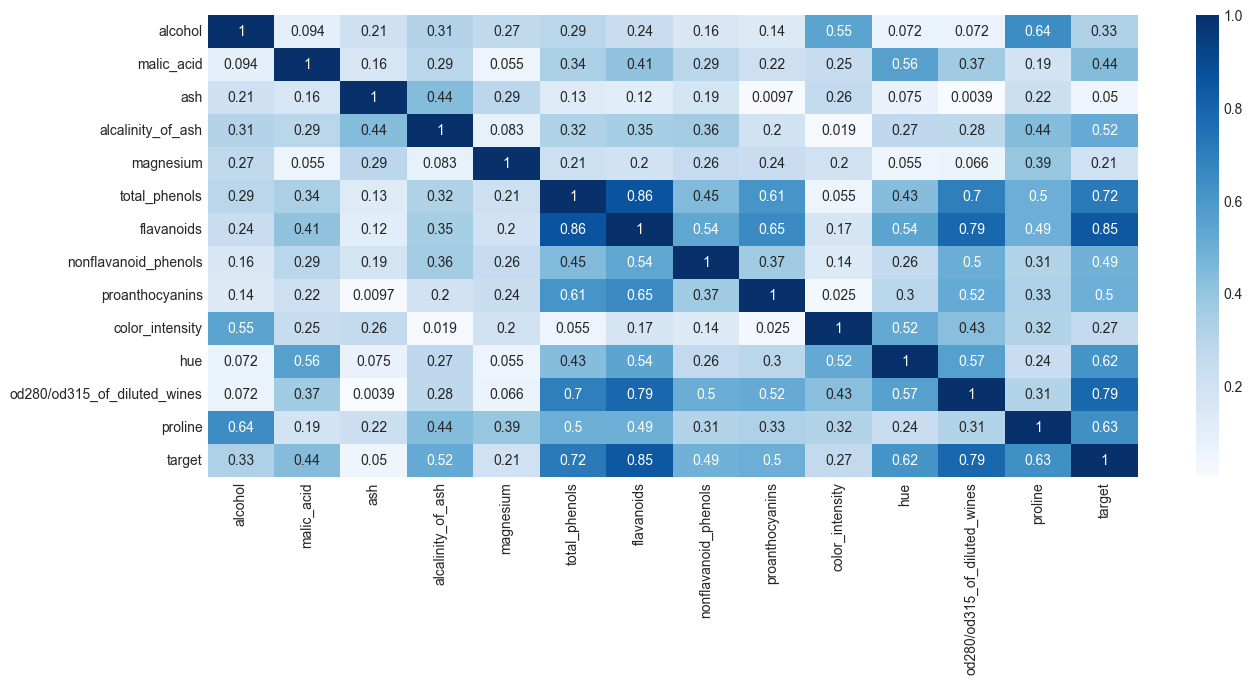

In [8]:
fig, ax = plt.subplots()
sns.heatmap(data_df.corr().abs(),
            ax = ax,
            cmap = 'Blues', 
            annot=True, 
            fmt = '.2g')

In [9]:
labels = data_df[data_df.columns[-1]]
feature_df = data_df.drop(data_df.columns[-1],axis = 1)
feature_df.shape,labels.shape

((178, 13), (178,))

In [10]:
X_train,X_test,y_train,y_test = train_test_split(feature_df,labels,
                                                stratify=labels,
                                                test_size=TEST_SIZE,
                                                 random_state = RANDOM_STATE)

In [11]:
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [12]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

<h1>Define Model</h1>

In [13]:
model = tf.keras.Sequential([
     tf.keras.Input(shape= (X_train.shape[1],)),
    tf.keras.layers.Dense(8,activation='relu'),
    tf.keras.layers.Dense(3)
])



In [14]:
print(model)

<Sequential name=sequential, built=True>


In [15]:
#funtional API

# inputs = tf.keras.Input(shape= (X_train.shape[1],))
# x = tf.keras.layers.Dense(8,activation='relu')(inputs)
# outpt = tf.keras.layers.Dense(3)(x)

# model1 = tf.keras.Model(inputs = inputs ,outputs = outpt)
# print(model1)

In [16]:
X_train[:1].shape

(1, 13)

In [17]:
# prediction = model(X_train[:1])
# prediction

prediction = model(X_train[:1]).numpy()
prediction.sum()

np.float32(2.594112)

In [18]:
tf.nn.softmax(prediction).numpy().sum()

np.float32(1.0)

In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 8)                   │             112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │              27 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 139 (556.00 B)

 Trainable params: 139 (556.00 B)

 Non-trainable params: 0 (0.00 B)

In [20]:
#loss function
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
#sparse crossentropy for 

In [21]:
loss_fn(y_train[:1],prediction)

<tf.Tensor: shape=(), dtype=float32, numpy=1.3107240200042725>

In [22]:
#optimizer s 
optimizer = tf.keras.optimizers.Adam(learning_rate=ALPHA)


In [23]:
#compiling model
model.compile(optimizer = optimizer,loss = loss_fn,metrics = ['accuracy'])


In [24]:
history = model.fit(X_train,y_train,validation_data = [X_test,y_test],epochs=EPOCHS)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.2606 - loss: 1.4008 - val_accuracy: 0.3333 - val_loss: 1.2079
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2817 - loss: 1.3543 - val_accuracy: 0.3333 - val_loss: 1.1654
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3028 - loss: 1.3112 - val_accuracy: 0.3333 - val_loss: 1.1259
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3239 - loss: 1.2700 - val_accuracy: 0.3611 - val_loss: 1.0887
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3380 - loss: 1.2313 - val_accuracy: 0.3889 - val_loss: 1.0539
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3662 - loss: 1.1948 - val_accuracy: 0.4167 - val_loss: 1.0212
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3662 - loss: 1.1602 - val_accuracy: 0.4167 - val_loss: 0.9904
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3732 - loss: 1.1274 - val_accuracy: 0.5000 - val_loss:

In [25]:
model.evaluate(X_test,y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9722 - loss: 0.1310


[0.13101492822170258, 0.9722222089767456]

<Axes: >

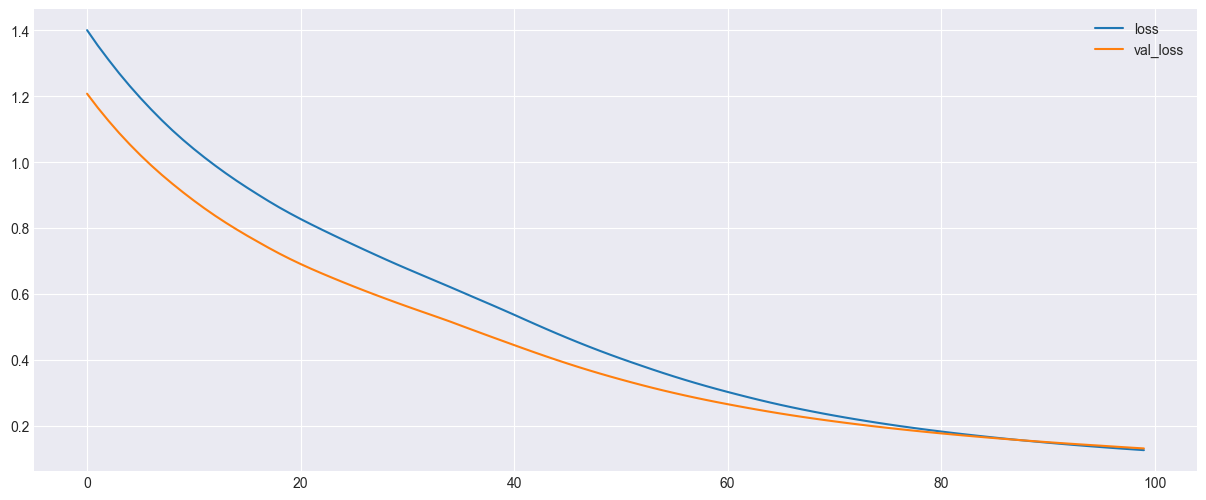

In [26]:
loss_df = pd.DataFrame(history.history)
loss_df.plot(y = ['loss','val_loss'],)

In [27]:
class_name = {}
for i ,cl in enumerate(le.classes_):
    class_name[i] = cl
class_name

{0: np.int64(0), 1: np.int64(1), 2: np.int64(2)}

<h1>PREDICTION</h1>

In [28]:
prob_model = tf.keras.Sequential([
    model,
    tf.keras.layers.Softmax()
])

In [34]:
y_pred = prob_model(X_train).numpy()
print(f'Accuracy : {accuracy_score(y_train,y_pred.argmax(axis = 1))}')
print(f'Accuracy : {classification_report(y_train,y_pred.argmax(axis = 1))}')
y_pred[0].sum()

Accuracy : 0.9859154929577465
Accuracy :               precision    recall  f1-score   support

           0       0.98      1.00      0.99        47
           1       1.00      0.96      0.98        57
           2       0.97      1.00      0.99        38

    accuracy                           0.99       142
   macro avg       0.98      0.99      0.99       142
weighted avg       0.99      0.99      0.99       142



np.float32(1.0000001)

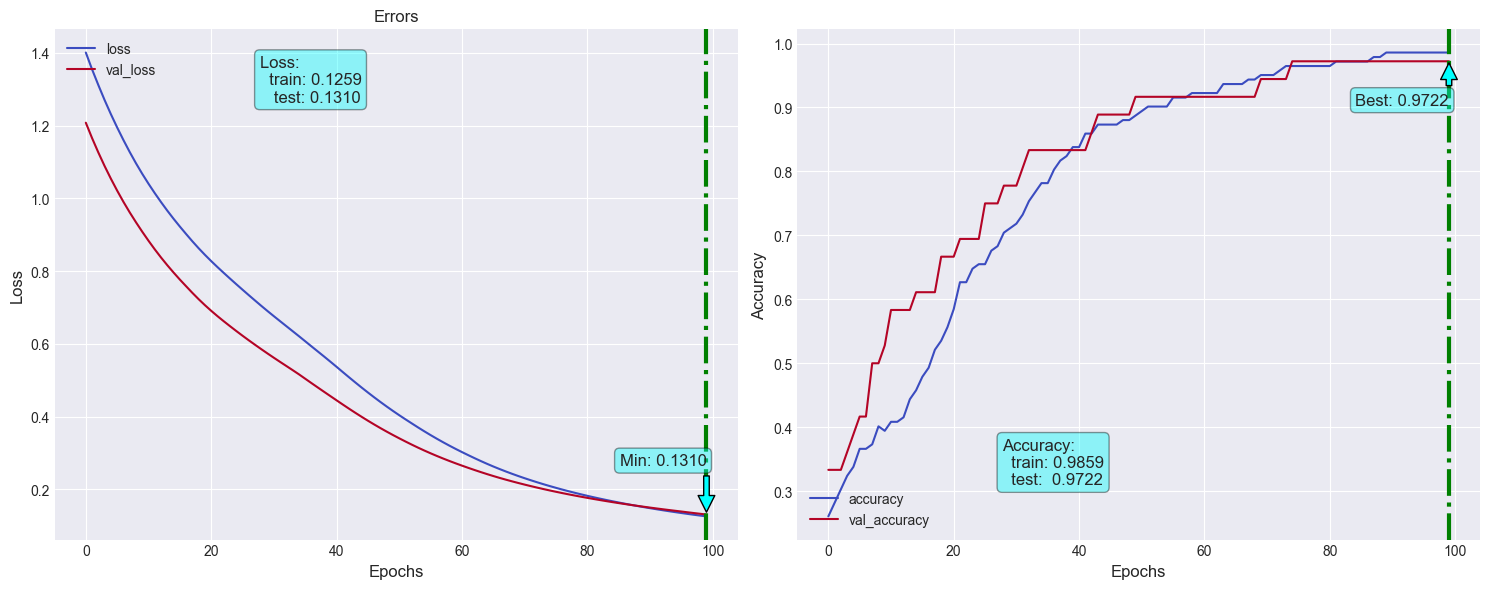

In [1]:
pwd

'D:\\Satyam\\Deep Learning\\day6'